In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import binarize

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from collections import Counter
from wordcloud import WordCloud

In [2]:
DATA_PATH = '/...'

# Read the CSV file using pd.read_csv
feature_matrix = pd.read_csv(f'{DATA_PATH}/feature_matrix.csv')

# Now you can work with the feature_matrix DataFrame
# feature_matrix.head()

In [3]:
# Read scores from eval_feature.py
with open(f"{DATA_PATH}/feature_scores.txt", "r") as f:
    feature_scores = eval(f.readline())

In [4]:
feature_names = list(feature_matrix.iloc[:,1:].columns)

In [5]:
# Split scores into model-specific scores
log_reg_scores, SNN_scores = zip(*feature_scores)
# Bind feature name with associated score
log_reg_scores = dict(zip(feature_names, log_reg_scores))
SNN_scores = dict(zip(feature_names, SNN_scores))
# Sort based on score
sorted_log_reg_scores = sorted(log_reg_scores.items(), key=lambda x: x[1])
sorted_SNN_scores = sorted(SNN_scores.items(), key=lambda x: x[1])

In [6]:
# Save top 40 features
top_log_reg = [name for name,_ in sorted_log_reg_scores[:40]]
top_SNN = [name for name,_ in sorted_SNN_scores[:40]]

In [7]:
# top_log_reg

### Logistic Regression Model Training:

In [8]:
X = feature_matrix[top_log_reg]
y = feature_matrix['FPF_TARGET']

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [10]:
# Creating a logistic regression model
model = LogisticRegression()

# Training the model
model.fit(X_train_std, y_train)

LogisticRegression()

### Model Evaluation

In [11]:
# Making predictions on the test set
y_pred = model.predict(X_test_std)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
# roc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Displaying results

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC_Accuracy: {roc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Accuracy: 0.8300
ROC_Accuracy: 0.5704

Confusion Matrix:
[[715  36]
 [116  27]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       751
         1.0       0.43      0.19      0.26       143

    accuracy                           0.83       894
   macro avg       0.64      0.57      0.58       894
weighted avg       0.79      0.83      0.80       894



### The Highest Effective Features (Shap Model)

This section analyzes the importance of features by shap model and based on the LogisticRegression().

In [21]:
shap_values_w = explainer.shap_values(X_test_std)

  0%|          | 0/894 [00:00<?, ?it/s]

In [47]:
shap_fratures = pd.DataFrame((shap_values_w), columns=feature_matrix[top_log_reg].columns.to_list())
shap_fratures.head()

,ESSENTIAL_SERVICES_slp,medianLOAN,BNPL_mean,meanCHILD_DEPENDENTS,total_balance,GENERAL_MERCHANDISE_prop,minCREDIT_CARD_PAYMENT,GROCERIES_count,meanGROCERIES,PETS_slp,...,RENT_count,TRAVEL_count,TAX_mean,UNCATEGORIZED_prop,ATM_CASH_slp,maxACCOUNT_FEES,maxEDUCATION,minAUTOMOTIVE,LOAN_mean,RENT_prop
0,0.001291,0.003233,0.000000,-0.004052,-0.005951,0.001903,0.000000,-0.000488,0.000789,-0.000585,...,0.006488,-0.012000,0.000000,0.004658,-0.001481,0.002249,0.000939,0.001203,0.004413,-0.024893
1,-0.006891,0.006249,0.001683,-0.010664,-0.006907,-0.033703,-0.001993,0.001463,0.019176,-0.002022,...,0.005927,-0.010153,0.001510,-0.002582,0.019682,-0.001251,0.000000,0.000460,-0.024086,0.004020
2,-0.005815,0.001467,0.001576,-0.013770,-0.003221,-0.051979,-0.001092,0.001297,-0.006395,-0.000691,...,-0.001180,-0.031242,-0.002878,-0.015202,-0.000940,0.002017,0.001584,0.000600,0.011079,0.003334
3,0.001390,0.031088,0.004117,0.000000,0.011797,0.007317,0.000000,0.017746,-0.006984,0.000000,...,-0.005842,0.351732,0.000991,0.009617,0.000000,0.000000,0.001570,0.004971,0.055261,0.013550
4,-0.004019,-0.017979,0.000000,-0.001679,0.021005,-0.008169,0.000000,0.000000,-0.001289,-0.000740,...,-0.001873,-0.007787,0.002335,-0.005615,0.000000,0.000970,-0.000513,0.000000,-0.019736,0.001136


## Most Effective Features

 **Single Customer Shap Graph**

Using 2084 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

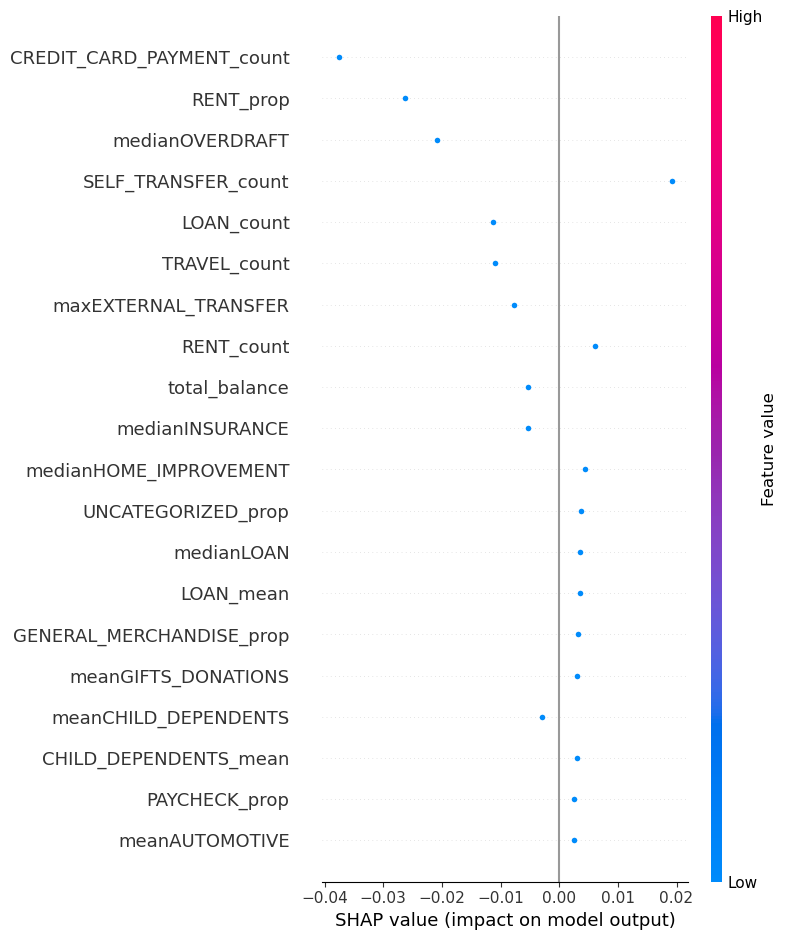

In [48]:
# Initialize a KernelExplainer with the model and training data
explainer = shap.KernelExplainer(model.predict, X_train_std)

# Calculate SHAP values for the specific prediction
shap_values = explainer.shap_values(X_test_std[[0]])

# Display the summary plot
shap.summary_plot(shap_values, X_test_std[[0]], feature_names=feature_matrix[top_log_reg].columns)

**All Customer Shap Graph**

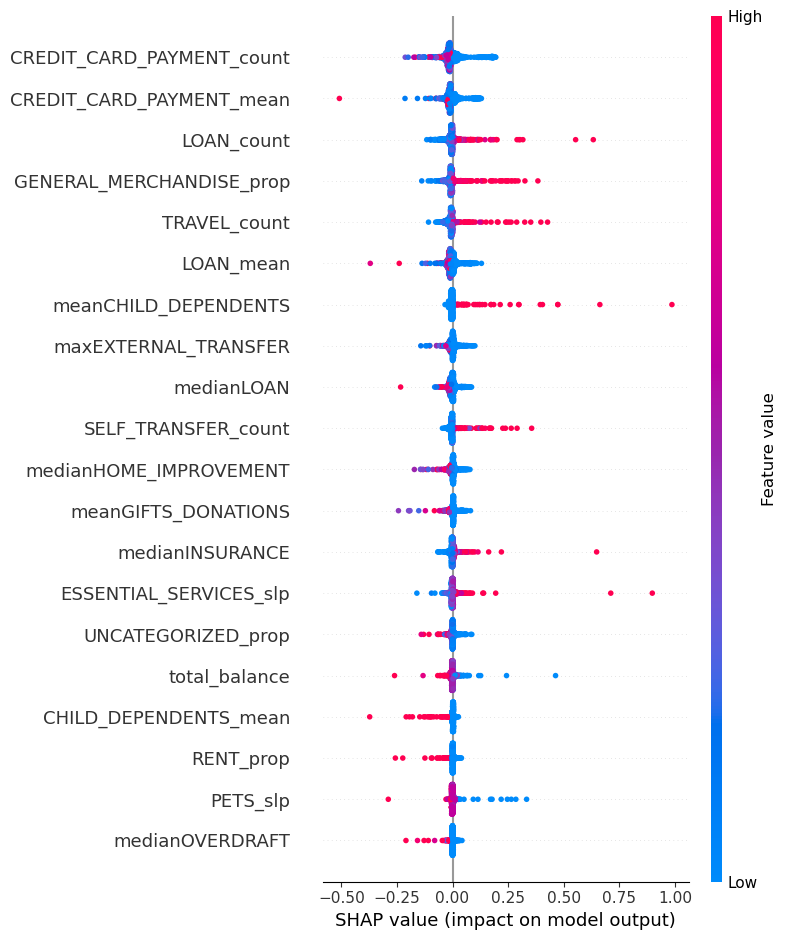

In [49]:
shap.summary_plot(shap_values_w, X_test_std, feature_names=feature_matrix[top_log_reg].columns)

In [60]:
top_5_features = shap_fratures.apply(lambda row: row.abs().nlargest(5).index.tolist(), axis=1)
# top_5_features

In [50]:
filtered_text = []
for i in top_5_features:
    for j in i:
        filtered_text.append(j)

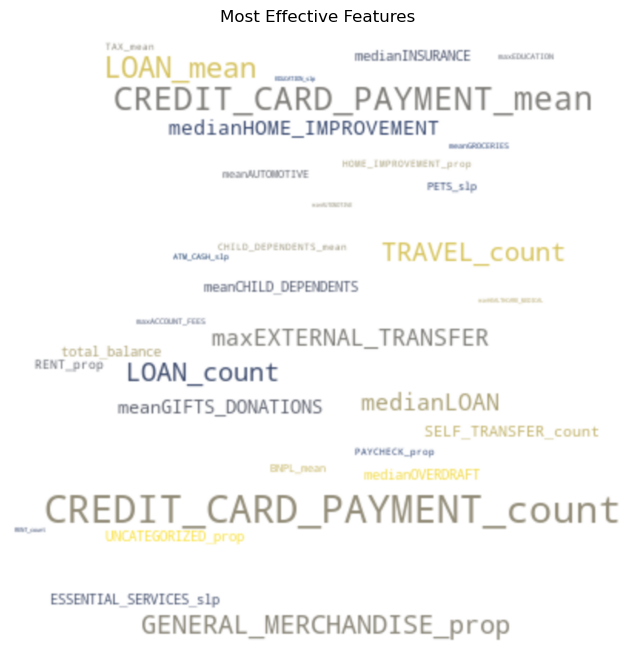

In [51]:
# Create a Counter from the list
dictionary = Counter(filtered_text)

# Generate WordCloud with specific settings
cloud = WordCloud(
    max_font_size=80,
    colormap="cividis",
    background_color="white",  # Set background color to white
    width=400,  # Set the width of the plot
    height=400,  # Set the height of the plot
).generate_from_frequencies(dictionary)

# Plot the WordCloud
plt.figure(figsize=(8, 8))  # Set the figure size to create a square plot
plt.imshow(cloud, interpolation='quadric')
plt.axis('off')
plt.title("Most Effective Features")
plt.show()

### Feature Groups

This code is organizing features into groups based on their occurrence in predefined feature lists. The purpose is to categorize and group similar features together for further analysis or interpretation.

**1. Financial_Transactions:**
This group includes features related to loans, credit card payments, account fees, and rent.
Examples: medianLOAN, CREDIT_CARD_PAYMENT_count, maxACCOUNT_FEES.

**2. Spending_Shopping:**
Features in this group are associated with general merchandise, groceries, automotive expenses, and travel.
Examples: GENERAL_MERCHANDISE_prop, meanGROCERIES, TRAVEL_count.

**3. Miscellaneous_Uncategorized:**
This group covers a variety of features related to family, pets, and other miscellaneous aspects.
Examples: HOME_IMPROVEMENT_prop, meanCHILD_DEPENDENTS, PETS_slp.

In [52]:
# Define feature groups
Financial_Transactions = ['SELF_TRANSFER_prop','medianLOAN', 'BNPL_mean', 'minCREDIT_CARD_PAYMENT',
                          'medianOVERDRAFT', 'CREDIT_CARD_PAYMENT_count',
                          'maxEXTERNAL_TRANSFER', 'minBILLS_UTILITIES',
                          'LOAN_count', 'maxACCOUNT_FEES', 'LOAN_mean',
                          'PAYCHECK_prop','SELF_TRANSFER_count', 
                          'CREDIT_CARD_PAYMENT_mean','BNPL_slp','total_balance','ATM_CASH_slp']
Spending_Shopping = ['ESSENTIAL_SERVICES_slp','GENERAL_MERCHANDISE_prop', 'meanGROCERIES',
                     'maxGROCERIES', 'meanAUTOMOTIVE', 'meanGIFTS_DONATIONS',
                     'medianHOME_IMPROVEMENT', 'medianINSURANCE', 'RENT_count',
                     'TRAVEL_count','TRAVEL_prop','minAUTOMOTIVE', 'RENT_prop']
Miscellaneous_Uncategorized = [ 'meanCHILD_DEPENDENTS',
                                'PETS_slp', 'HOME_IMPROVEMENT_prop',
                                'CHILD_DEPENDENTS_mean',  'minHEALTHCARE_MEDICAL', 'EDUCATION_slp',
                                'UNCATEGORIZED_prop',  'maxEDUCATION',]

In [53]:
def assign_group_from_features(feature_list, financial_transactions, spending_shopping, miscellaneous_uncategorized):
    categories = {'Financial_Transactions': financial_transactions,
                  'Spending_Shopping': spending_shopping,
                  'Miscellaneous_Uncategorized': miscellaneous_uncategorized}
    
    counters = {category: sum(1 for feature in feature_list if feature in categories[category]) for category in categories}
    return max(counters, key=counters.get)


In [54]:
Feature_Groups = [assign_group_from_features(feature_list, Financial_Transactions, Spending_Shopping, Miscellaneous_Uncategorized) for feature_list in top_5_features]

In [57]:
X_test['Feature_Groups'] = Feature_Groups
X_test.head()

,ESSENTIAL_SERVICES_slp,medianLOAN,BNPL_mean,meanCHILD_DEPENDENTS,total_balance,GENERAL_MERCHANDISE_prop,minCREDIT_CARD_PAYMENT,GROCERIES_count,meanGROCERIES,PETS_slp,...,TRAVEL_count,TAX_mean,UNCATEGORIZED_prop,ATM_CASH_slp,maxACCOUNT_FEES,maxEDUCATION,minAUTOMOTIVE,LOAN_mean,RENT_prop,Feature_Groups
2405,19.006000,11.00,0.0,0.0,3406.808611,0.240423,10.68,4.285714,39.951333,0.0,...,1.000000,0.00,0.000000,218.857143,0.0,0.00,1.06,27.908333,0.074951,Financial_Transactions
2851,-18.161143,19.99,0.0,0.0,2138.655307,0.045270,0.00,10.000000,161.140143,0.0,...,3.428571,0.00,0.044382,-1484.297857,25.0,8.21,2.29,178.051190,0.000015,Financial_Transactions
1710,-13.400000,50.00,0.0,0.0,-798.228492,0.012750,0.00,12.714286,18.532360,0.0,...,1.000000,194.28,0.109301,55.357143,2.5,0.00,1.50,24.520455,0.000000,Financial_Transactions
1113,-4.142571,24.95,0.0,0.0,-215.958333,0.191636,0.00,48.571429,4.336059,0.0,...,47.285714,0.00,0.021024,-114.420000,0.0,0.00,0.21,23.161600,0.000000,Financial_Transactions
964,-40.000000,670.00,0.0,0.0,-28663.992568,0.038220,0.00,1.333333,24.117500,0.0,...,0.000000,0.00,0.144888,0.000000,0.0,0.00,1.99,606.690000,0.000000,Financial_Transactions


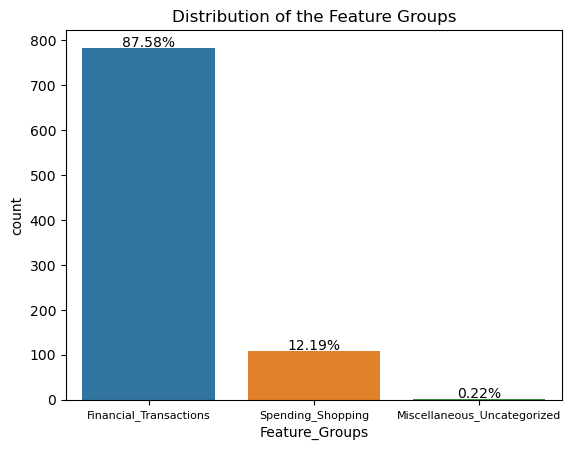

In [59]:
ax = sns.countplot(data=X_test, x="Feature_Groups")

# Calculate percentage for each category
total = len(X_test["Feature_Groups"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            f'{height / total:.2%}', ha="center", fontsize=10)

plt.xticks(fontsize=8)
plt.title("Distribution of the Feature Groups")
plt.show()